In [1]:
import torch
import torchvision.transforms as transforms
import numpy as np
from simclr import SimCLR
from torchvision import transforms

# Capsule Network
from capsule_network import resnet20
from norb import smallNORB
# ref https://discuss.pytorch.org/t/difference-between-torch-manual-seed-and-torch-cuda-manual-seed/13848/7
seed_value = 42
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `pytorch` pseudo-random generator at a fixed value
import torch
torch.manual_seed(seed_value)


Load the test loader

In [2]:
def get_test_loader(data_dir,
                    dataset,
                    batch_size, 
                    num_workers=4,
                    pin_memory=False):

    data_dir = data_dir + '/' + dataset

    from torchvision.transforms import InterpolationMode
    if dataset == "smallNorb":
        trans = [
                transforms.Resize(48, interpolation=InterpolationMode.BICUBIC),
                transforms.CenterCrop(32),
                transforms.ToTensor(),
                 ]
        dataset = smallNORB(data_dir, train=False, download=True,
                                transform=transforms.Compose(trans))

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    print("type of test_loader", type(data_loader))
    print("Length of test_loader", len(data_loader))
    return data_loader


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': False}

# now we import testing dataset
batch_size = 64
test_loader = get_test_loader("./data", "smallNorb", batch_size, **kwargs)
num_test = len(test_loader.dataset)
print("Length of testing dataset", num_test)

# initialize ResNet
from simclr.modules.resnet_hacks import modify_resnet_model
from simclr.modules import get_resnet

encoder = get_resnet("resnet18", pretrained=False)
modified_resnet = modify_resnet_model(encoder)
capsule_network = resnet20(16, {'size': 32, 'channels': 3, 'classes': 10}, 32, 16, 1, mode="EM").to(device)

# initialize model
model = SimCLR(encoder, capsule_network)
checkpoint = torch.load("checkpoints/EM_simclr_fine_tune_after_pretrained_ckpt_epoch_20.tar", map_location=device)  
model.load_state_dict(checkpoint['model_state'], strict=True)
model = model.to(device)
model = model.eval()


type of test_loader <class 'torch.utils.data.dataloader.DataLoader'>
Length of test_loader 760
Length of testing dataset 48600


c:\Users\athac\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\athac\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
import torch
import json
# all of our models had 32 capsules
num_capsules = 32
# initialise them as 0
accumulated_activations = torch.zeros(num_capsules, device=device)

# Counter for the number of validation samples
num_samples = 0

for i, (x, y) in enumerate(test_loader):
    x = x.to(device) 
    with torch.no_grad(): 
        out = model(x)
    # Sum activations across the spatial dimensions for each capsule
    # and accumulate these sums across all validation samples
    accumulated_activations += torch.sum(out, dim=[0, 2, 3])
    # count the batches that have been processed
    num_samples += x.size(0)

# our activations are 4x4 (check the resnet file for more)
# so we divide by 16 to get the average activation per capsule element
average_activations = accumulated_activations / (num_samples * 16)  

average_activations_list = average_activations.cpu().tolist()

# Sanity checks
print("num_samples", num_samples)
print("accumulated_activations", accumulated_activations)
print("Average activations per capsule element:", average_activations_list)

# Save them to a JSON file for proof
data_to_save = {
    "capsule_averages": average_activations_list
}
file_path = 'capsules_averages/EM_fine_tune_capsule_averages_all.json'
with open(file_path, 'w') as f:
    json.dump(data_to_save, f, indent=4)

print(f"Saved activations averages to {file_path}")

num_samples 48600
accumulated_activations tensor([  216.3454,   683.2183,  2669.2310,  2680.9951,   203.2564,   204.4341,
          186.7303,  8567.4033,   241.9622,    88.6842,   169.8346,   206.8764,
          186.2670,   184.7664,  4016.0422,   185.2912,  6965.9976,    99.5034,
          260.2798,   176.6169, 15654.6387,  2010.4631,   197.2817,   255.2466,
          125.9855,   197.5242,   200.0267,   237.8407,  1165.1249,  5700.4336,
         1793.4182,    63.9226], device='cuda:0')
Average activations per capsule element: [0.0002782219962682575, 0.0008786243270151317, 0.0034326529130339622, 0.0034477817825973034, 0.00026138938846997917, 0.0002629038935992867, 0.00024013670918066055, 0.011017750948667526, 0.00031116537866182625, 0.00011404855467844754, 0.00021840872068423778, 0.00026604480808600783, 0.00023954091011546552, 0.00023761109332554042, 0.005164663307368755, 0.0002382860257057473, 0.008958330377936363, 0.00012796225200872868, 0.00033472198992967606, 0.0002271307894261554,

Convert to a List for easier process

In [5]:
values_list = []
for value in data_to_save.values():
    values_list.extend(value)  
print("Flattened list of values:", values_list)

Flattened list of values: [0.0002782219962682575, 0.0008786243270151317, 0.0034326529130339622, 0.0034477817825973034, 0.00026138938846997917, 0.0002629038935992867, 0.00024013670918066055, 0.011017750948667526, 0.00031116537866182625, 0.00011404855467844754, 0.00021840872068423778, 0.00026604480808600783, 0.00023954091011546552, 0.00023761109332554042, 0.005164663307368755, 0.0002382860257057473, 0.008958330377936363, 0.00012796225200872868, 0.00033472198992967606, 0.0002271307894261554, 0.020131994038820267, 0.002585472073405981, 0.00025370591902174056, 0.0003282492107246071, 0.0001620183902559802, 0.000254017737461254, 0.0002572359226178378, 0.0003058650472667068, 0.0014983601868152618, 0.007330804597586393, 0.0023063505068421364, 8.220498420996591e-05]


round to 2 decimals as per the literature
https://arxiv.org/abs/2305.11178

In [6]:
avg = [round(num, 2) for num in values_list]
avg

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.01,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.01,
 0.0,
 0.01,
 0.0,
 0.0,
 0.0,
 0.02,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.01,
 0.0,
 0.0]

Visualisation

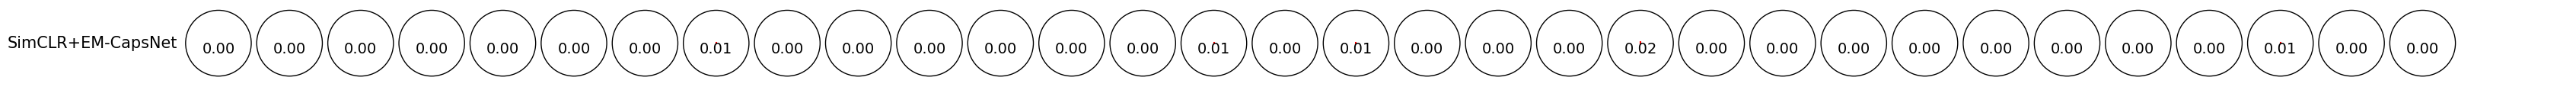

In [7]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

activations = avg 

fig, ax = plt.subplots(figsize=(34, 2.8))

# this is the space between circles
space_between_circles = 0.3 

# I make a circle for each capsule
for i, activation in enumerate(activations):
    circle_center = i * (1 + space_between_circles) + 1  
    circle = plt.Circle((circle_center, 0), 0.6, color='black', fill=False)
    ax.add_patch(circle)
    ax.plot([circle_center, circle_center], [0, activation], color='red')  
    ax.text(circle_center, -0.1, f'{activation:.2f}', ha='center', va='center', fontsize=14)

# add the name before the capsules at left 
ax.text(-1.3, 0, 'SimCLR+EM-CapsNet', ha='center', va='center', fontsize=15)
ax.set_aspect('equal')
ax.axis('off')

# save into pdf for higher quality
plt.tight_layout()
plt.savefig('graphs_for_thesis/simclr_em_smallnorb_fine_tune.pdf', format='pdf')  
plt.show()